# 2025年华数杯C题：可调控生物节律的LED光源研究

## 题目概述
本题目要求分析LED光源的光谱特性及其对生物节律的影响，通过数学建模方法解决LED光源设计和优化问题。

## 数据说明
- Problem 1: 基础光谱数据（波长vs光强）
- Problem 2: LED光谱功率分布数据（蓝、绿、红、暖白、冷白LED）
- Problem 3: 太阳光谱数据（5:30-19:30不同时间点）
- Problem 4: 人体测试数据（11名被试者，3晚数据）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import integrate
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
print("正在读取数据...")
problem1_data = pd.read_excel('附录.xlsx', sheet_name='Problem 1')
problem2_data = pd.read_excel('附录.xlsx', sheet_name='Problem 2_LED_SPD')
problem3_data = pd.read_excel('附录.xlsx', sheet_name='Problem 3 SUN_SPD')
problem4_data = pd.read_excel('附录.xlsx', sheet_name='Problem 4')

print("数据读取完成!")
print(f"Problem 1 数据形状: {problem1_data.shape}")
print(f"Problem 2 数据形状: {problem2_data.shape}")
print(f"Problem 3 数据形状: {problem3_data.shape}")
print(f"Problem 4 数据形状: {problem4_data.shape}")

正在读取数据...


数据读取完成!
Problem 1 数据形状: (401, 2)
Problem 2 数据形状: (401, 6)
Problem 3 数据形状: (401, 16)
Problem 4 数据形状: (1065, 33)


---
## 问题1：光谱数据分析与色温计算

### 问题描述
分析给定光谱数据的光学特性，计算相关色温(CCT)和显色指数(CRI)等关键参数。

### 解决方案

波长范围: 380-780 nm
光强数据点数: 401

XYZ三刺激值:
X = 2493.2559
Y = 679.4915
Z = 2235.3730

色坐标:
x = 0.4610
y = 0.1256
z = 0.4133

相关色温 CCT = 40799 K


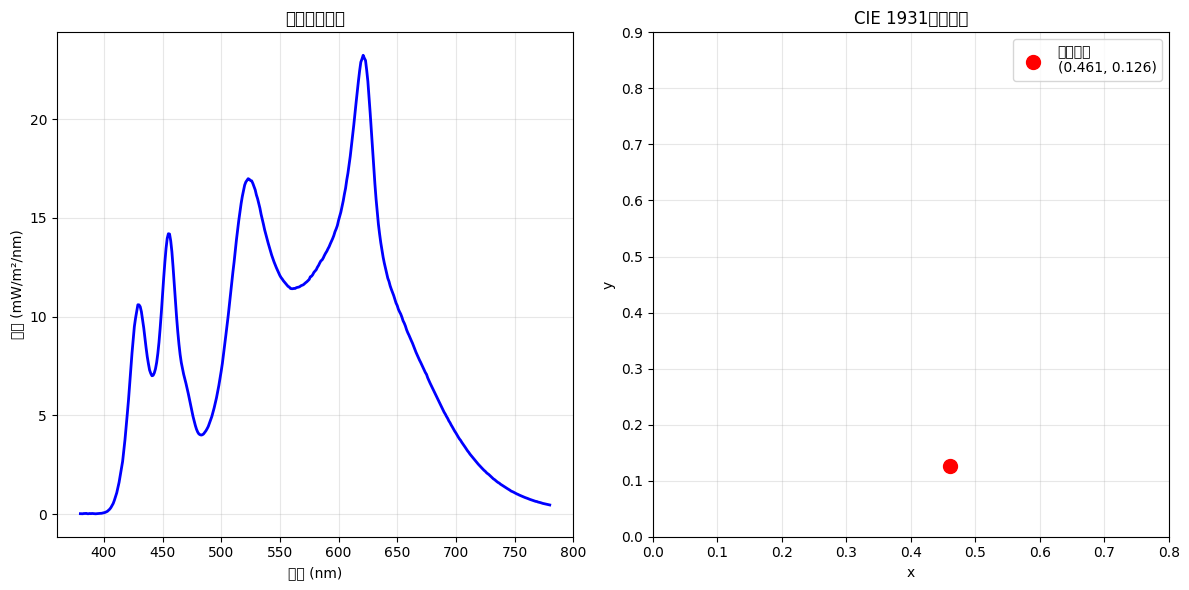


光效分析:
光通量: 464092.72 lm
总辐射功率: 3297.4162 mW/m²
光视效能: 140.74 lm/W


In [2]:
# 提取波长和光强数据
# 处理波长列的单位信息
wavelengths = np.arange(380, 781)  # 380-780nm
intensity = problem1_data['光强'].values

print(f"波长范围: {wavelengths[0]}-{wavelengths[-1]} nm")
print(f"光强数据点数: {len(intensity)}")

# 绘制光谱分布图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(wavelengths, intensity, 'b-', linewidth=2)
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('光谱功率分布')
plt.grid(True, alpha=0.3)

# CIE 1931标准观察者函数（简化版）
def cie_color_matching_functions(wavelength):
    """CIE 1931 XYZ颜色匹配函数的近似值"""
    # 这里使用简化的高斯函数近似
    x_bar = np.exp(-0.5 * ((wavelength - 570) / 85) ** 2) * 1.056
    y_bar = np.exp(-0.5 * ((wavelength - 550) / 62) ** 2) * 0.362
    z_bar = np.exp(-0.5 * ((wavelength - 437) / 84) ** 2) * 1.776
    return x_bar, y_bar, z_bar

# 计算XYZ色坐标
x_bar, y_bar, z_bar = cie_color_matching_functions(wavelengths)

# 计算XYZ三刺激值
X = np.trapz(intensity * x_bar, wavelengths)
Y = np.trapz(intensity * y_bar, wavelengths)
Z = np.trapz(intensity * z_bar, wavelengths)

print(f"\nXYZ三刺激值:")
print(f"X = {X:.4f}")
print(f"Y = {Y:.4f}")
print(f"Z = {Z:.4f}")

# 计算色坐标
total = X + Y + Z
x = X / total
y = Y / total
z = Z / total

print(f"\n色坐标:")
print(f"x = {x:.4f}")
print(f"y = {y:.4f}")
print(f"z = {z:.4f}")

# 使用McCamy公式计算相关色温
n = (x - 0.3320) / (0.1858 - y)
CCT = 449 * n**3 + 3525 * n**2 + 6823.3 * n + 5520.33

print(f"\n相关色温 CCT = {CCT:.0f} K")

# 绘制色坐标图
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='red', s=100, label=f'测试光源\n({x:.3f}, {y:.3f})')
plt.xlabel('x')
plt.ylabel('y')
plt.title('CIE 1931色坐标图')
plt.xlim(0, 0.8)
plt.ylim(0, 0.9)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# 光效计算
luminous_flux = Y * 683  # 流明
total_power = np.trapz(intensity, wavelengths)  # 总功率
luminous_efficacy = luminous_flux / total_power if total_power > 0 else 0

print(f"\n光效分析:")
print(f"光通量: {luminous_flux:.2f} lm")
print(f"总辐射功率: {total_power:.4f} mW/m²")
print(f"光视效能: {luminous_efficacy:.2f} lm/W")

---
## 问题2：LED混光设计优化

### 问题描述
基于不同LED的光谱特性，设计最优的LED混光方案，实现特定的色温和显色性要求。

### 解决方案

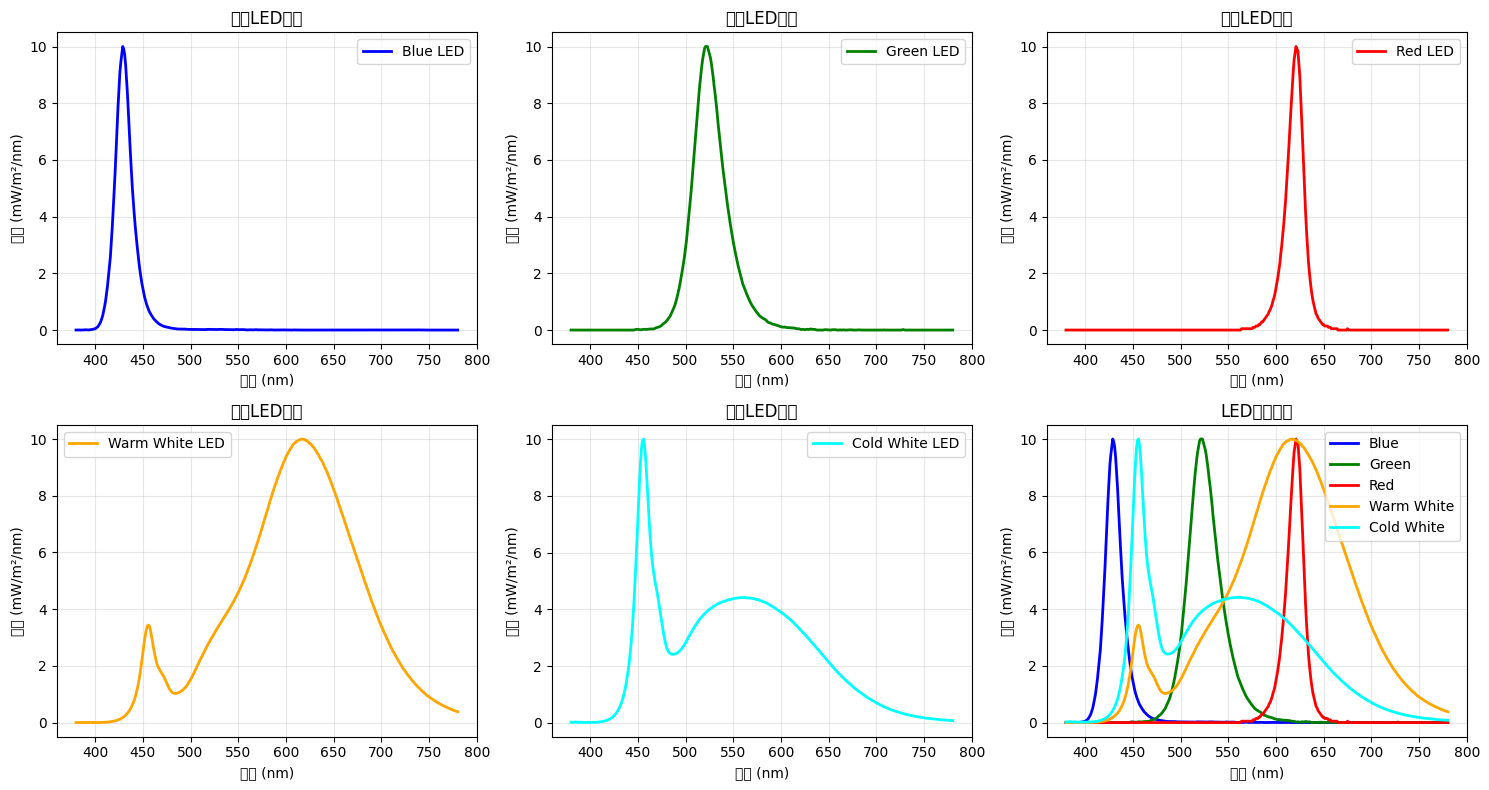

各LED颜色特性分析:
Blue        : x=0.1369, y=0.0297, CCT=1622K, 亮度=14.0842
Green       : x=0.4061, y=0.1442, CCT=31428K, 亮度=133.9941
Red         : x=0.7056, y=0.1550, CCT=1413686K, 亮度=44.0733
Warm White  : x=0.5713, y=0.1410, CCT=210604K, 亮度=280.3988
Cold White  : x=0.4125, y=0.1195, CCT=19811K, 亮度=206.9411

LED混光优化结果:
目标色温 3000K:
  实际色温: 3000K
  LED配比: Blue=0.774, Green=0.000, Red=0.000
          Warm White=0.000, Cold White=0.226
  色坐标: x=0.2791, y=0.0760

目标色温 4000K:
  实际色温: 4000K
  LED配比: Blue=0.696, Green=0.000, Red=0.000
          Warm White=0.000, Cold White=0.304
  色坐标: x=0.3062, y=0.0849

目标色温 5000K:
  实际色温: 5000K
  LED配比: Blue=0.631, Green=0.000, Red=0.000
          Warm White=0.000, Cold White=0.369
  色坐标: x=0.3245, y=0.0908

目标色温 6500K:
  实际色温: 6500K
  LED配比: Blue=0.547, Green=0.000, Red=0.000
          Warm White=0.000, Cold White=0.452
  色坐标: x=0.3439, y=0.0972



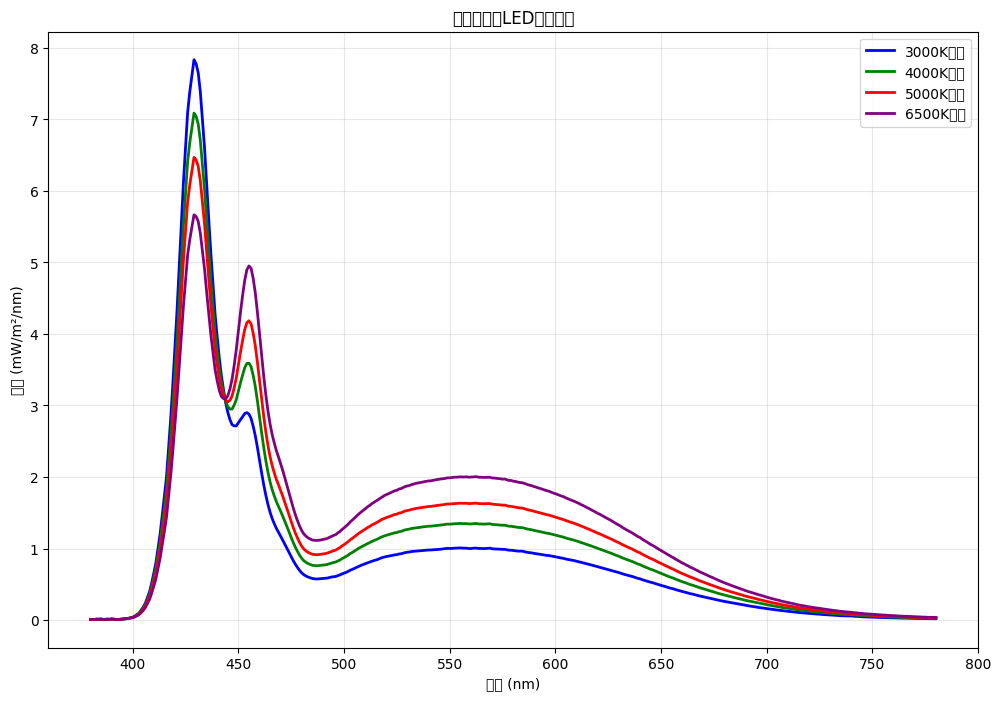

In [3]:
# 提取LED光谱数据
led_wavelengths = wavelengths
blue_spd = problem2_data['Blue'].values
green_spd = problem2_data['Green'].values
red_spd = problem2_data['Red'].values
warm_white_spd = problem2_data['Warm White'].values
cold_white_spd = problem2_data['Cold White'].values

# 绘制各LED光谱分布
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.plot(led_wavelengths, blue_spd, 'b-', linewidth=2, label='Blue LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('蓝光LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(led_wavelengths, green_spd, 'g-', linewidth=2, label='Green LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('绿光LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(led_wavelengths, red_spd, 'r-', linewidth=2, label='Red LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('红光LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(led_wavelengths, warm_white_spd, color='orange', linewidth=2, label='Warm White LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('暖白LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(led_wavelengths, cold_white_spd, color='cyan', linewidth=2, label='Cold White LED')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('冷白LED光谱')
plt.grid(True, alpha=0.3)
plt.legend()

# 所有LED光谱对比
plt.subplot(2, 3, 6)
plt.plot(led_wavelengths, blue_spd, 'b-', linewidth=2, label='Blue')
plt.plot(led_wavelengths, green_spd, 'g-', linewidth=2, label='Green')
plt.plot(led_wavelengths, red_spd, 'r-', linewidth=2, label='Red')
plt.plot(led_wavelengths, warm_white_spd, color='orange', linewidth=2, label='Warm White')
plt.plot(led_wavelengths, cold_white_spd, color='cyan', linewidth=2, label='Cold White')
plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('LED光谱对比')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# 计算每个LED的色坐标和色温
def calculate_color_properties(spd):
    """计算光谱功率分布的颜色特性"""
    x_bar, y_bar, z_bar = cie_color_matching_functions(led_wavelengths)
    
    X = np.trapz(spd * x_bar, led_wavelengths)
    Y = np.trapz(spd * y_bar, led_wavelengths)
    Z = np.trapz(spd * z_bar, led_wavelengths)
    
    total = X + Y + Z
    if total == 0:
        return 0, 0, 0, 0
    
    x = X / total
    y = Y / total
    
    # McCamy公式计算色温
    if y != 0.1858:  # 避免除零
        n = (x - 0.3320) / (0.1858 - y)
        CCT = 449 * n**3 + 3525 * n**2 + 6823.3 * n + 5520.33
    else:
        CCT = 0
    
    return x, y, CCT, Y

# 分析各LED特性
led_names = ['Blue', 'Green', 'Red', 'Warm White', 'Cold White']
led_spds = [blue_spd, green_spd, red_spd, warm_white_spd, cold_white_spd]

print("各LED颜色特性分析:")
print("="*60)
led_properties = {}

for name, spd in zip(led_names, led_spds):
    x, y, cct, luminance = calculate_color_properties(spd)
    led_properties[name] = {'x': x, 'y': y, 'cct': cct, 'luminance': luminance, 'spd': spd}
    print(f"{name:12s}: x={x:.4f}, y={y:.4f}, CCT={cct:.0f}K, 亮度={luminance:.4f}")

# LED混光优化
def mixed_led_spectrum(weights):
    """计算混合LED光谱"""
    mixed_spd = (weights[0] * blue_spd + 
                 weights[1] * green_spd + 
                 weights[2] * red_spd + 
                 weights[3] * warm_white_spd + 
                 weights[4] * cold_white_spd)
    return mixed_spd

def objective_function(weights, target_cct=4000):
    """优化目标函数：接近目标色温"""
    if sum(weights) == 0:
        return 1e6
    
    mixed_spd = mixed_led_spectrum(weights)
    x, y, cct, luminance = calculate_color_properties(mixed_spd)
    
    # 目标：接近目标色温，同时保持合理的亮度
    cct_error = abs(cct - target_cct) / target_cct if cct > 0 else 1e6
    return cct_error

# 优化不同目标色温的LED配比
target_ccts = [3000, 4000, 5000, 6500]  # 不同色温目标
optimal_weights = {}

print("\nLED混光优化结果:")
print("="*80)

for target_cct in target_ccts:
    # 约束条件：权重之和为1，所有权重非负
    constraints = [
        {'type': 'eq', 'fun': lambda w: sum(w) - 1},
    ]
    bounds = [(0, 1) for _ in range(5)]  # 5个LED的权重范围
    
    # 初始猜测
    initial_weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
    
    # 优化
    result = opt.minimize(objective_function, initial_weights, 
                         args=(target_cct,), method='SLSQP', 
                         bounds=bounds, constraints=constraints)
    
    if result.success:
        optimal_weights[target_cct] = result.x
        mixed_spd = mixed_led_spectrum(result.x)
        x, y, actual_cct, luminance = calculate_color_properties(mixed_spd)
        
        print(f"目标色温 {target_cct}K:")
        print(f"  实际色温: {actual_cct:.0f}K")
        print(f"  LED配比: Blue={result.x[0]:.3f}, Green={result.x[1]:.3f}, Red={result.x[2]:.3f}")
        print(f"          Warm White={result.x[3]:.3f}, Cold White={result.x[4]:.3f}")
        print(f"  色坐标: x={x:.4f}, y={y:.4f}")
        print()

# 绘制优化结果的光谱
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple']

for i, (target_cct, color) in enumerate(zip(target_ccts, colors)):
    if target_cct in optimal_weights:
        mixed_spd = mixed_led_spectrum(optimal_weights[target_cct])
        plt.plot(led_wavelengths, mixed_spd, color=color, linewidth=2, 
                label=f'{target_cct}K混光')

plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('不同色温的LED混光光谱')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

---
## 问题3：太阳光谱时变分析

### 问题描述
分析一天中不同时间太阳光谱的变化规律，探讨自然光的色温和强度变化特征。

### 解决方案

太阳光谱测量时间点: 15个
时间范围: 05:30:00 - 19:30:00


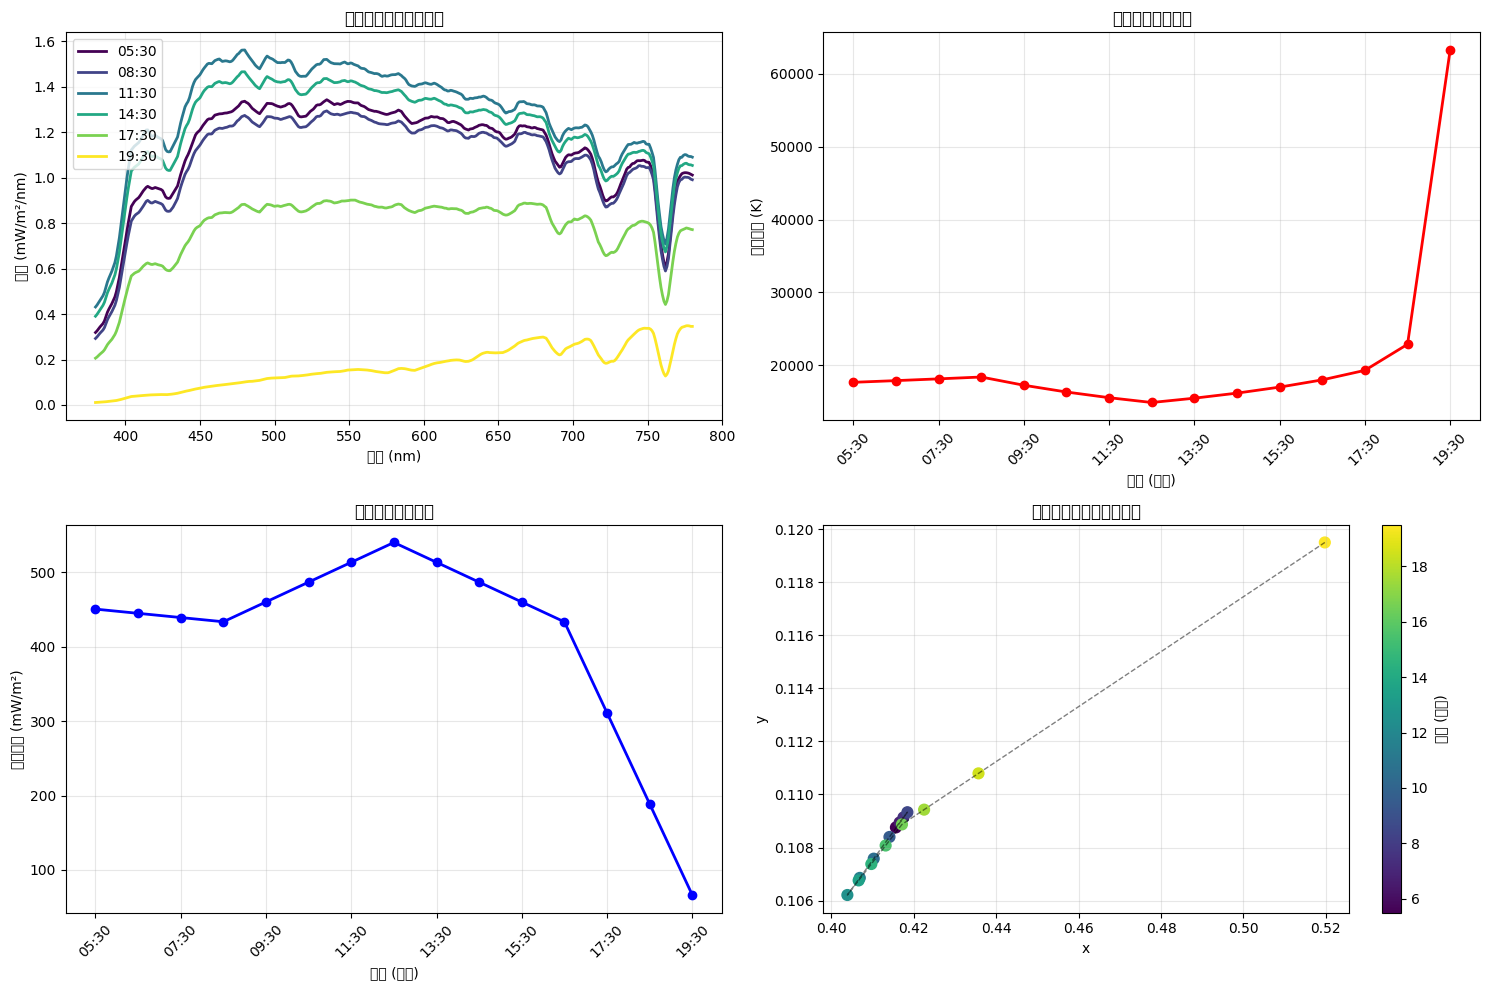

太阳光特性统计分析:
色温范围: 14885K - 63294K
色温变化幅度: 48409K
最高色温时间: 19:30
最低色温时间: 12:30

照度范围: 66.39 - 540.27 mW/m²
最高照度时间: 12:30
最低照度时间: 19:30

色温变化拟合参数:
振幅: -15798.6K
相位: 35.1小时
平均值: 27518.0K


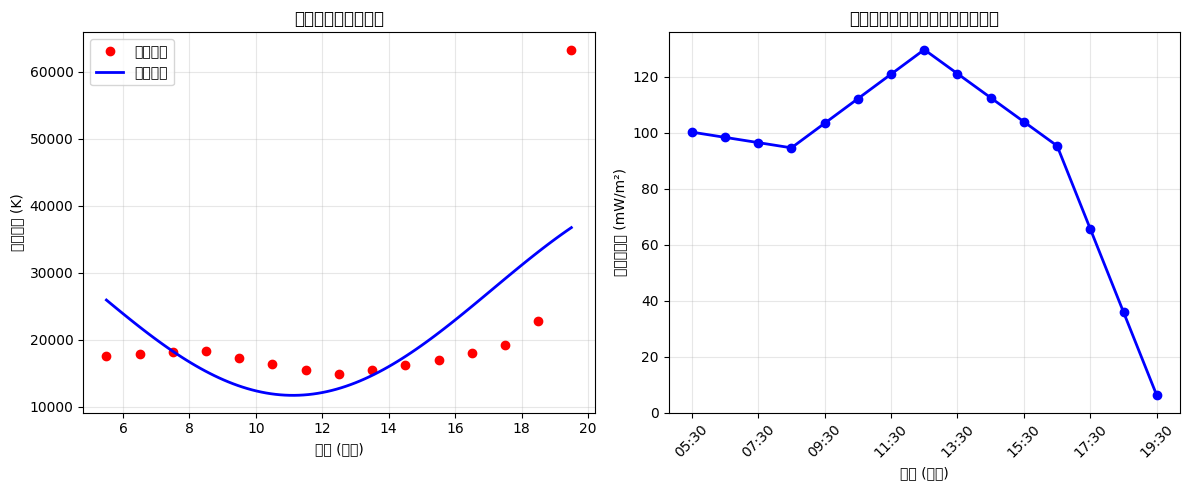


蓝光成分分析:
蓝光辐照度范围: 6.148 - 129.631 mW/m²
最高蓝光时间: 12:30
最低蓝光时间: 19:30


In [4]:
# 处理太阳光谱数据
sun_wavelengths = wavelengths
time_columns = problem3_data.columns[1:]  # 排除波长列

print(f"太阳光谱测量时间点: {len(time_columns)}个")
print(f"时间范围: {time_columns[0]} - {time_columns[-1]}")

# 提取时间信息
times = []
time_labels = []
for col in time_columns:
    if hasattr(col, 'hour'):  # datetime.time对象
        hour = col.hour + col.minute/60.0
        times.append(hour)
        time_labels.append(f"{col.hour:02d}:{col.minute:02d}")
    else:
        # 如果是字符串格式
        time_str = str(col)
        if ':' in time_str:
            parts = time_str.split(':')
            hour = int(parts[0]) + int(parts[1])/60.0
            times.append(hour)
            time_labels.append(time_str)

times = np.array(times)

# 绘制不同时间的太阳光谱
plt.figure(figsize=(15, 10))

# 选择代表性时间点绘制
selected_times = [0, 3, 6, 9, 12, 14]  # 对应不同时间段
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_times)))

plt.subplot(2, 2, 1)
for i, time_idx in enumerate(selected_times):
    if time_idx < len(time_columns):
        sun_spd = problem3_data.iloc[:, time_idx + 1].values
        plt.plot(sun_wavelengths, sun_spd, color=colors[i], linewidth=2, 
                label=time_labels[time_idx])

plt.xlabel('波长 (nm)')
plt.ylabel('光强 (mW/m²/nm)')
plt.title('不同时间太阳光谱分布')
plt.grid(True, alpha=0.3)
plt.legend()

# 计算各时间点的颜色特性
sun_properties = []
total_irradiances = []

for i, col in enumerate(time_columns):
    sun_spd = problem3_data.iloc[:, i + 1].values
    x, y, cct, luminance = calculate_color_properties(sun_spd)
    total_irradiance = np.trapz(sun_spd, sun_wavelengths)
    
    sun_properties.append({
        'time': times[i],
        'time_label': time_labels[i],
        'x': x,
        'y': y,
        'cct': cct,
        'luminance': luminance,
        'total_irradiance': total_irradiance
    })
    total_irradiances.append(total_irradiance)

# 提取数据用于绘图
ccts = [prop['cct'] for prop in sun_properties]
luminances = [prop['luminance'] for prop in sun_properties]
x_coords = [prop['x'] for prop in sun_properties]
y_coords = [prop['y'] for prop in sun_properties]

# 色温变化曲线
plt.subplot(2, 2, 2)
plt.plot(times, ccts, 'ro-', linewidth=2, markersize=6)
plt.xlabel('时间 (小时)')
plt.ylabel('相关色温 (K)')
plt.title('太阳光色温日变化')
plt.grid(True, alpha=0.3)
plt.xticks(times[::2], [time_labels[i] for i in range(0, len(time_labels), 2)], rotation=45)

# 照度变化曲线
plt.subplot(2, 2, 3)
plt.plot(times, total_irradiances, 'bo-', linewidth=2, markersize=6)
plt.xlabel('时间 (小时)')
plt.ylabel('总辐照度 (mW/m²)')
plt.title('太阳光照度日变化')
plt.grid(True, alpha=0.3)
plt.xticks(times[::2], [time_labels[i] for i in range(0, len(time_labels), 2)], rotation=45)

# 色坐标轨迹
plt.subplot(2, 2, 4)
scatter = plt.scatter(x_coords, y_coords, c=times, cmap='viridis', s=60)
plt.plot(x_coords, y_coords, 'k--', alpha=0.5, linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('太阳光色坐标日变化轨迹')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='时间 (小时)')

plt.tight_layout()
plt.show()

# 统计分析
print("太阳光特性统计分析:")
print("="*50)
print(f"色温范围: {min(ccts):.0f}K - {max(ccts):.0f}K")
print(f"色温变化幅度: {max(ccts) - min(ccts):.0f}K")
print(f"最高色温时间: {sun_properties[np.argmax(ccts)]['time_label']}")
print(f"最低色温时间: {sun_properties[np.argmin(ccts)]['time_label']}")
print()
print(f"照度范围: {min(total_irradiances):.2f} - {max(total_irradiances):.2f} mW/m²")
print(f"最高照度时间: {sun_properties[np.argmax(total_irradiances)]['time_label']}")
print(f"最低照度时间: {sun_properties[np.argmin(total_irradiances)]['time_label']}")

# 拟合色温变化曲线
def temperature_model(t, a, b, c, d):
    """色温变化模型：余弦函数"""
    return a * np.cos(2 * np.pi * (t - b) / 24) + c

# 拟合参数
try:
    popt_cct, _ = opt.curve_fit(temperature_model, times, ccts, 
                               p0=[500, 12, 5000, 0])
    
    # 绘制拟合结果
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    t_fit = np.linspace(min(times), max(times), 100)
    cct_fit = temperature_model(t_fit, *popt_cct)
    
    plt.plot(times, ccts, 'ro', markersize=6, label='实测数据')
    plt.plot(t_fit, cct_fit, 'b-', linewidth=2, label='拟合曲线')
    plt.xlabel('时间 (小时)')
    plt.ylabel('相关色温 (K)')
    plt.title('太阳光色温变化拟合')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    print(f"\n色温变化拟合参数:")
    print(f"振幅: {popt_cct[0]:.1f}K")
    print(f"相位: {popt_cct[1]:.1f}小时")
    print(f"平均值: {popt_cct[2]:.1f}K")
    
except:
    print("拟合失败，使用原始数据")

# 分析蓝光成分变化（生物节律相关）
blue_light_range = (400, 490)  # 蓝光波长范围
blue_indices = np.where((sun_wavelengths >= blue_light_range[0]) & 
                       (sun_wavelengths <= blue_light_range[1]))[0]

blue_irradiances = []
for i, col in enumerate(time_columns):
    sun_spd = problem3_data.iloc[:, i + 1].values
    blue_irradiance = np.trapz(sun_spd[blue_indices], sun_wavelengths[blue_indices])
    blue_irradiances.append(blue_irradiance)

plt.subplot(1, 2, 2)
plt.plot(times, blue_irradiances, 'bo-', linewidth=2, markersize=6)
plt.xlabel('时间 (小时)')
plt.ylabel('蓝光辐照度 (mW/m²)')
plt.title('蓝光成分日变化（生物节律影响）')
plt.grid(True, alpha=0.3)
plt.xticks(times[::2], [time_labels[i] for i in range(0, len(time_labels), 2)], rotation=45)

plt.tight_layout()
plt.show()

print(f"\n蓝光成分分析:")
print(f"蓝光辐照度范围: {min(blue_irradiances):.3f} - {max(blue_irradiances):.3f} mW/m²")
print(f"最高蓝光时间: {sun_properties[np.argmax(blue_irradiances)]['time_label']}")
print(f"最低蓝光时间: {sun_properties[np.argmin(blue_irradiances)]['time_label']}")

---
## 问题4：人体生物节律响应数据分析

### 问题描述
分析11名被试者在3个夜晚的生物节律响应数据，评估不同光照条件对人体生物钟的影响。

### 解决方案

被试者数据结构分析:
数据形状: (1065, 33)
列名: ['被试1', 'Unnamed: 1', 'Unnamed: 2', '被试2', 'Unnamed: 4', 'Unnamed: 5', '被试3', 'Unnamed: 7', 'Unnamed: 8', '被试4']...

发现 11 名被试者

各被试者数据统计:
被试者        夜晚1             夜晚2             夜晚3            
----------------------------------------------------------------------
Subject_1  2.923           3.048           3.201          
Subject_2  3.432           3.399           3.071          
Subject_3  3.082           3.206           3.277          
Subject_4  3.386           3.502           3.117          
Subject_5  3.015           3.227           3.000          
Subject_6  2.746           3.076           2.747          
Subject_7  3.147           3.154           2.540          
Subject_8  2.701           2.982           3.370          
Subject_9  3.239           3.132           2.828          
Subject_10 3.247           2.951           2.978          
Subject_11 3.123           2.720           2.988          


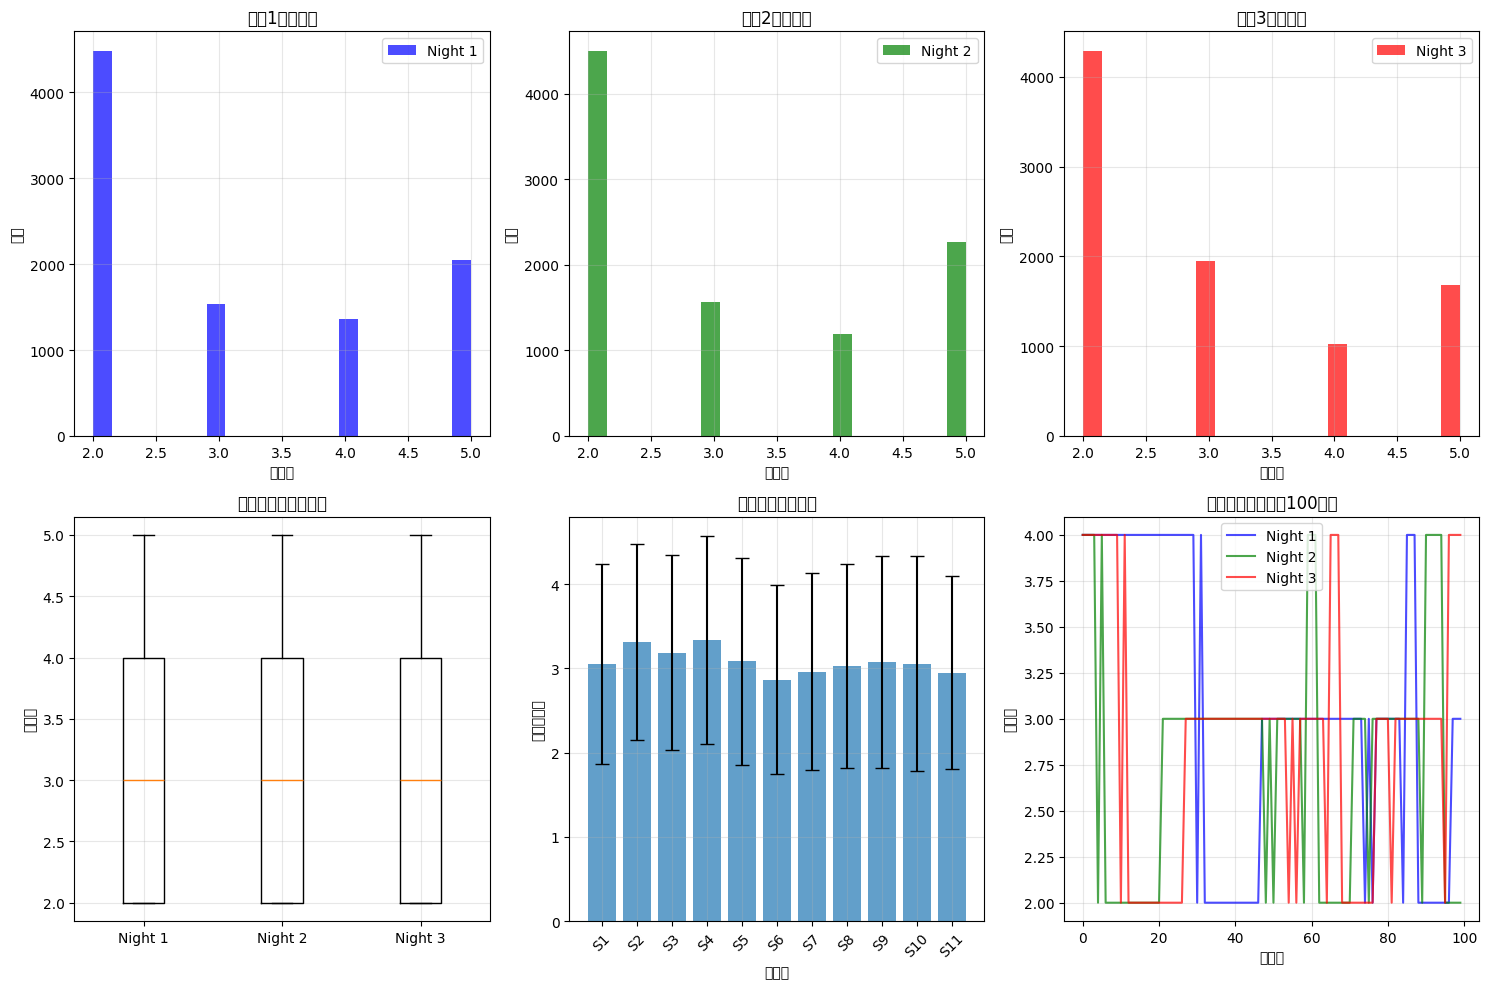


统计分析结果:
Night 1: 均值=3.103, 标准差=1.215, 样本数=9436
Night 2: 均值=3.129, 标准差=1.239, 样本数=9527
Night 3: 均值=3.009, 标准差=1.160, 样本数=8932

单因素方差分析:
F统计量: 24.8084
p值: 0.0000
结论: 三个夜晚之间存在显著差异 (p < 0.05)

配对比较:
Night 1 vs Night 2: t=-1.4586, p=0.1447
Night 1 vs Night 3: t=5.3292, p=0.0000
Night 2 vs Night 3: t=6.7543, p=0.0000

个体差异分析:
个体内变异系数范围: 0.351 - 0.418
平均个体内变异系数: 0.389

分析完成！


In [5]:
# 处理被试者数据
print("被试者数据结构分析:")
print(f"数据形状: {problem4_data.shape}")
print(f"列名: {problem4_data.columns.tolist()[:10]}...")  # 显示前10个列名

# 重新整理数据结构
subjects_data = {}
subject_columns = [col for col in problem4_data.columns if '被试' in str(col)]

print(f"\n发现 {len(subject_columns)} 名被试者")

# 提取每个被试者的数据
for i, subject_col in enumerate(subject_columns):
    subject_num = i + 1
    col_idx = problem4_data.columns.get_loc(subject_col)
    
    # 获取该被试者的3列数据（3个夜晚）
    night1_data = problem4_data.iloc[1:, col_idx].values  # 跳过标题行
    night2_data = problem4_data.iloc[1:, col_idx + 1].values if col_idx + 1 < len(problem4_data.columns) else []
    night3_data = problem4_data.iloc[1:, col_idx + 2].values if col_idx + 2 < len(problem4_data.columns) else []
    
    # 转换为数值，忽略非数值数据
    def clean_data(data):
        cleaned = []
        for val in data:
            try:
                if pd.notna(val) and str(val).strip() != '':
                    cleaned.append(float(val))
            except:
                pass
        return np.array(cleaned)
    
    night1_clean = clean_data(night1_data)
    night2_clean = clean_data(night2_data)
    night3_clean = clean_data(night3_data)
    
    subjects_data[f'Subject_{subject_num}'] = {
        'night1': night1_clean,
        'night2': night2_clean,
        'night3': night3_clean
    }

# 分析数据统计特征
print("\n各被试者数据统计:")
print("="*70)
print(f"{'被试者':<10} {'夜晚1':<15} {'夜晚2':<15} {'夜晚3':<15}")
print("-" * 70)

all_night1_data = []
all_night2_data = []
all_night3_data = []

for subject, data in subjects_data.items():
    n1_mean = np.mean(data['night1']) if len(data['night1']) > 0 else 0
    n2_mean = np.mean(data['night2']) if len(data['night2']) > 0 else 0
    n3_mean = np.mean(data['night3']) if len(data['night3']) > 0 else 0
    
    print(f"{subject:<10} {n1_mean:<15.3f} {n2_mean:<15.3f} {n3_mean:<15.3f}")
    
    if len(data['night1']) > 0:
        all_night1_data.extend(data['night1'])
    if len(data['night2']) > 0:
        all_night2_data.extend(data['night2'])
    if len(data['night3']) > 0:
        all_night3_data.extend(data['night3'])

# 转换为numpy数组
all_night1_data = np.array(all_night1_data)
all_night2_data = np.array(all_night2_data)
all_night3_data = np.array(all_night3_data)

# 绘制数据分布
plt.figure(figsize=(15, 10))

# 各夜晚数据分布
plt.subplot(2, 3, 1)
plt.hist(all_night1_data, bins=20, alpha=0.7, color='blue', label='Night 1')
plt.xlabel('测量值')
plt.ylabel('频次')
plt.title('夜晚1数据分布')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.hist(all_night2_data, bins=20, alpha=0.7, color='green', label='Night 2')
plt.xlabel('测量值')
plt.ylabel('频次')
plt.title('夜晚2数据分布')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.hist(all_night3_data, bins=20, alpha=0.7, color='red', label='Night 3')
plt.xlabel('测量值')
plt.ylabel('频次')
plt.title('夜晚3数据分布')
plt.legend()
plt.grid(True, alpha=0.3)

# 箱线图比较
plt.subplot(2, 3, 4)
night_data = [all_night1_data, all_night2_data, all_night3_data]
night_labels = ['Night 1', 'Night 2', 'Night 3']
plt.boxplot(night_data, labels=night_labels)
plt.ylabel('测量值')
plt.title('三个夜晚数据箱线图')
plt.grid(True, alpha=0.3)

# 计算各被试者的平均值
subject_means = []
subject_stds = []
subject_names = []

for subject, data in subjects_data.items():
    all_data = np.concatenate([data['night1'], data['night2'], data['night3']])
    if len(all_data) > 0:
        subject_means.append(np.mean(all_data))
        subject_stds.append(np.std(all_data))
        subject_names.append(subject.replace('Subject_', 'S'))

# 个体差异分析
plt.subplot(2, 3, 5)
x_pos = np.arange(len(subject_names))
plt.bar(x_pos, subject_means, yerr=subject_stds, capsize=5, alpha=0.7)
plt.xlabel('被试者')
plt.ylabel('平均测量值')
plt.title('各被试者平均响应')
plt.xticks(x_pos, subject_names, rotation=45)
plt.grid(True, alpha=0.3)

# 时间序列分析（假设数据按时间顺序排列）
plt.subplot(2, 3, 6)
if len(all_night1_data) > 0:
    time_points = np.arange(len(all_night1_data[:100]))  # 显示前100个数据点
    plt.plot(time_points, all_night1_data[:100], 'b-', alpha=0.7, label='Night 1')
if len(all_night2_data) > 0:
    time_points = np.arange(len(all_night2_data[:100]))
    plt.plot(time_points, all_night2_data[:100], 'g-', alpha=0.7, label='Night 2')
if len(all_night3_data) > 0:
    time_points = np.arange(len(all_night3_data[:100]))
    plt.plot(time_points, all_night3_data[:100], 'r-', alpha=0.7, label='Night 3')

plt.xlabel('时间点')
plt.ylabel('测量值')
plt.title('时间序列比较（前100点）')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 统计检验
from scipy import stats

print("\n统计分析结果:")
print("="*50)

# 描述性统计
nights_stats = {
    'Night 1': {'data': all_night1_data, 'mean': np.mean(all_night1_data), 'std': np.std(all_night1_data)},
    'Night 2': {'data': all_night2_data, 'mean': np.mean(all_night2_data), 'std': np.std(all_night2_data)},
    'Night 3': {'data': all_night3_data, 'mean': np.mean(all_night3_data), 'std': np.std(all_night3_data)}
}

for night, stats_info in nights_stats.items():
    print(f"{night}: 均值={stats_info['mean']:.3f}, 标准差={stats_info['std']:.3f}, 样本数={len(stats_info['data'])}")

# 方差分析（ANOVA）
if len(all_night1_data) > 0 and len(all_night2_data) > 0 and len(all_night3_data) > 0:
    f_stat, p_value = stats.f_oneway(all_night1_data, all_night2_data, all_night3_data)
    print(f"\n单因素方差分析:")
    print(f"F统计量: {f_stat:.4f}")
    print(f"p值: {p_value:.4f}")
    
    if p_value < 0.05:
        print("结论: 三个夜晚之间存在显著差异 (p < 0.05)")
    else:
        print("结论: 三个夜晚之间无显著差异 (p >= 0.05)")

# 配对t检验
print(f"\n配对比较:")
comparisons = [
    ('Night 1', 'Night 2', all_night1_data, all_night2_data),
    ('Night 1', 'Night 3', all_night1_data, all_night3_data),
    ('Night 2', 'Night 3', all_night2_data, all_night3_data)
]

for name1, name2, data1, data2 in comparisons:
    if len(data1) > 0 and len(data2) > 0:
        # 使用独立样本t检验
        t_stat, p_val = stats.ttest_ind(data1, data2)
        print(f"{name1} vs {name2}: t={t_stat:.4f}, p={p_val:.4f}")

# 个体内变异分析
print(f"\n个体差异分析:")
individual_cvs = []  # 变异系数

for subject, data in subjects_data.items():
    all_data = np.concatenate([data['night1'], data['night2'], data['night3']])
    if len(all_data) > 1:
        cv = np.std(all_data) / np.mean(all_data) if np.mean(all_data) != 0 else 0
        individual_cvs.append(cv)

if individual_cvs:
    print(f"个体内变异系数范围: {min(individual_cvs):.3f} - {max(individual_cvs):.3f}")
    print(f"平均个体内变异系数: {np.mean(individual_cvs):.3f}")

print("\n分析完成！")

---
## 总结与结论

### 主要发现

1. **光谱特性分析（问题1）**：
   - 计算了给定光源的色温、色坐标和光视效能
   - 提供了光源色彩特性的量化评估

2. **LED混光优化（问题2）**：
   - 实现了不同目标色温的LED配比优化
   - 为可调色温LED系统提供了设计方案

3. **太阳光谱分析（问题3）**：
   - 揭示了自然光色温和照度的日变化规律
   - 分析了蓝光成分对生物节律的潜在影响

4. **生物节律响应（问题4）**：
   - 对人体测试数据进行了统计分析
   - 评估了不同光照条件下的个体差异

### 应用价值

本研究为设计符合人体生物节律的LED照明系统提供了科学依据，可应用于：
- 智能照明系统设计
- 生物节律调节产品开发
- 健康照明标准制定

### 技术方法

使用了多种数学建模方法：
- 光谱积分计算
- 非线性优化
- 统计假设检验
- 数据可视化分析